In [3]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from collections import Counter
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [ ]:
df = pd.read_csv('SMOTE_data.csv')
df_normal = pd.read_csv('hikari_data.csv')
df_balanced = pd.read_csv('balanced_data.csv')

X_normal, y_normal = df_normal.drop('traffic_category', axis=1), df_normal['traffic_category']
X_smote, y_smote = df.drop('traffic_category', axis=1), df['traffic_category']
X_balanced, y_balanced = df_balanced.drop('traffic_category', axis=1), df_balanced['traffic_category']

In [4]:
scaler = MinMaxScaler()
X_scaled_smote = scaler.fit_transform(X_smote)
X_scaled_normal = scaler.fit_transform(X_normal)
X_scaled_balanced = scaler.fit_transform(X_balanced)


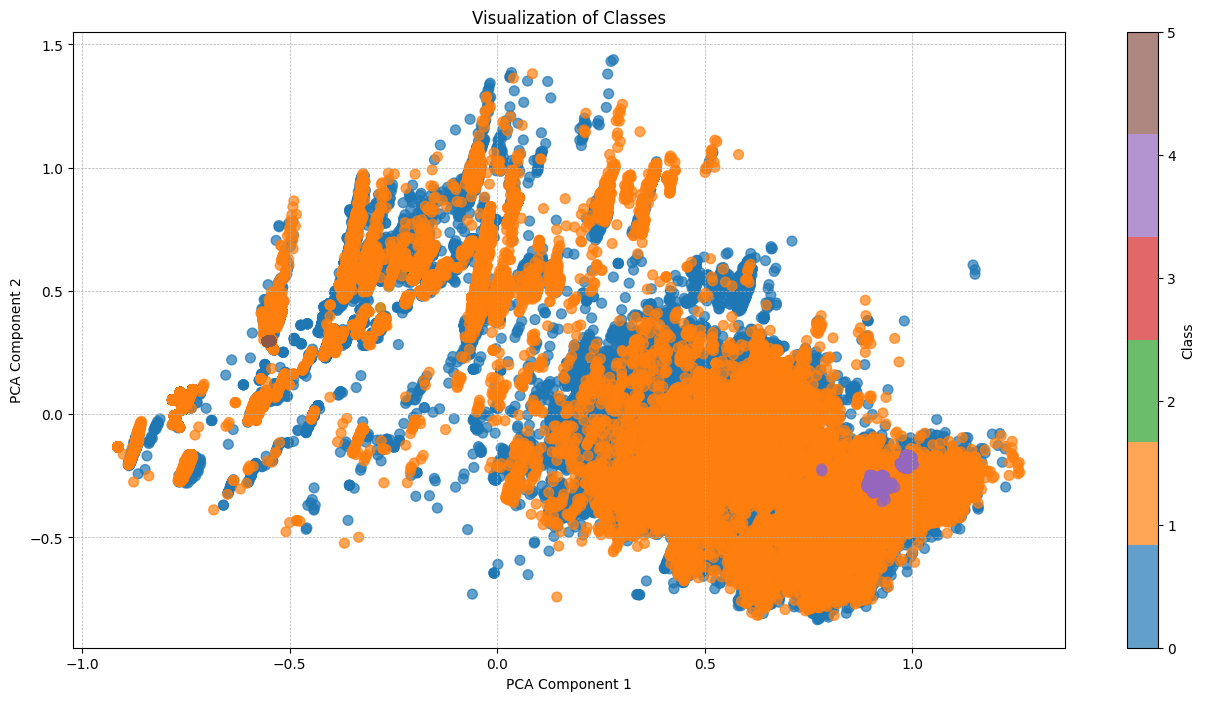

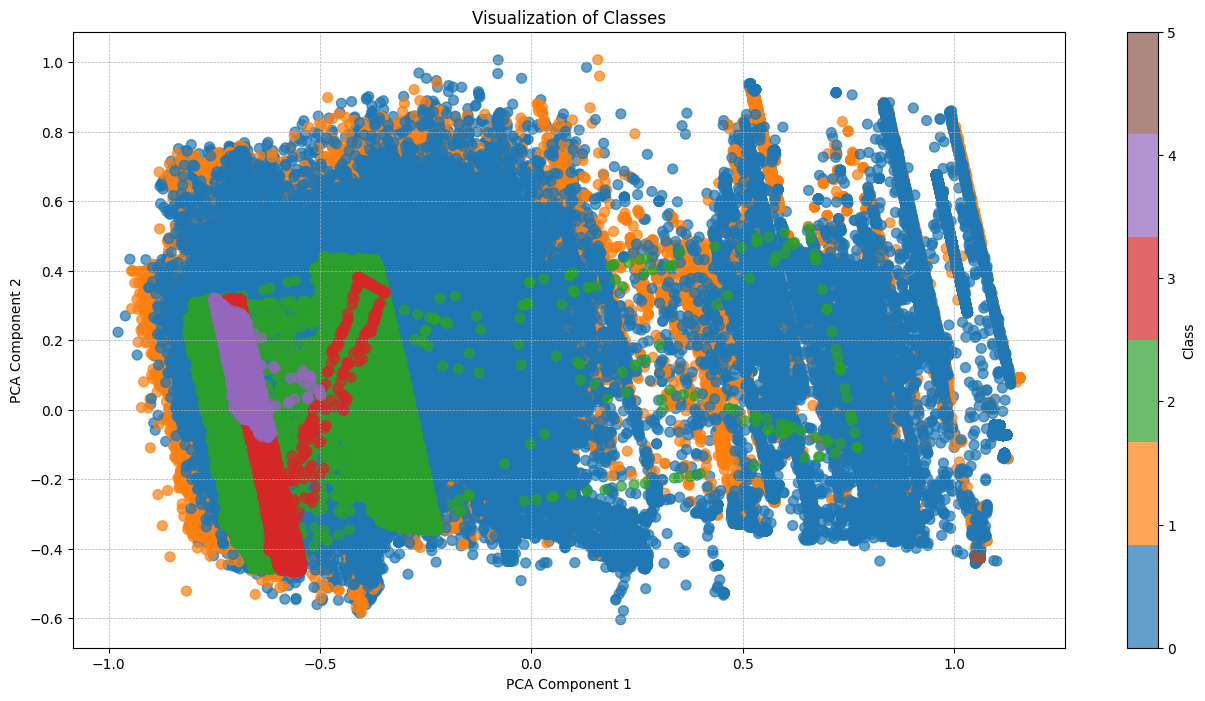

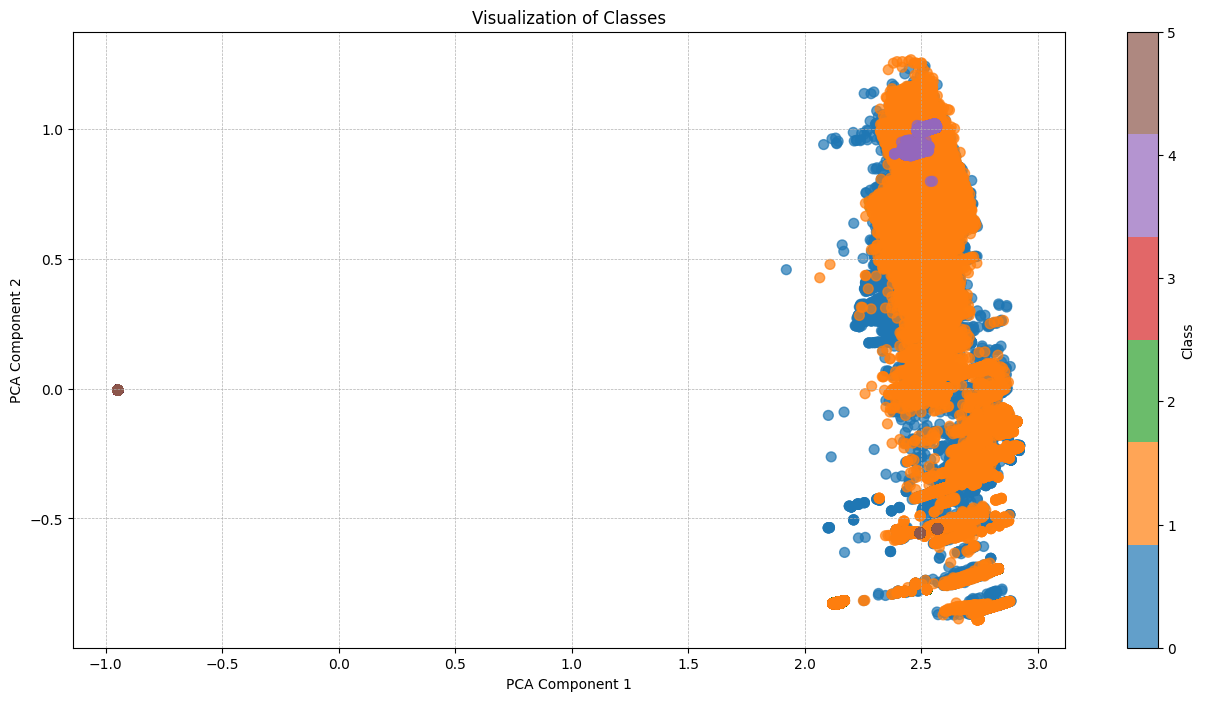

In [ ]:

def plot_dimension(dataX, dataY):
    unique_classes = np.unique(dataY) 
    n_classes = len(unique_classes) 
      
    cmap = ListedColormap(plt.cm.tab10.colors[:n_classes])

    plt.figure(figsize=(16, 8))
    scatter = plt.scatter(dataX[:, 0], dataX[:, 1], c=dataY, cmap=cmap, alpha=0.7, s=50)
    colorbar = plt.colorbar(scatter, ticks=range(n_classes))  
    colorbar.set_label('Class')

    plt.title("Visualization of Classes")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

pca = PCA(n_components=2)
X_pca_normal = pca.fit_transform(X_scaled_normal)
plot_dimension(X_pca_normal, y_normal)

X_pca_smote = pca.fit_transform(X_scaled_smote)
plot_dimension(X_pca_smote, y_smote)

X_pca_balanced = pca.fit_transform(X_scaled_balanced)
plot_dimension(X_pca_balanced, y_balanced)


In [12]:
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from collections import Counter
import concurrent.futures

def calculate_centroids(dataX, dataY, unique_classes):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda cls: np.mean(dataX[dataY == cls], axis=0), unique_classes))
    return np.array(results)

def calculate_metrics(dataX, dataY, sample_size=250000):
   
    if len(dataX) > sample_size:
        idx = np.random.choice(len(dataX), sample_size, replace=False)
        dataX = dataX[idx]
        dataY = dataY[idx]

    sil_score = silhouette_score(dataX, dataY)

    unique_classes = np.unique(dataY)
    class_centroids = calculate_centroids(dataX, dataY, unique_classes)

    centroid_distances = cdist(class_centroids, class_centroids)
    np.fill_diagonal(centroid_distances, np.inf)
    cluster_sep_index = np.min(centroid_distances)

    class_counts = Counter(dataY)
    total_samples = len(dataY)
    probabilities = np.array([count / total_samples for count in class_counts.values()])
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Menghindari log(0)

    print("Silhouette Score:", sil_score)
    print("Cluster Separation Index:", cluster_sep_index)
    print("Entropy (Class Distribution Balance):", entropy)

    return sil_score, cluster_sep_index, entropy



In [13]:
print("Metrics for Normal Dataset:")
calculate_metrics(X_pca_normal, y_normal)

print("Metrics for SMOTE Dataset:")
calculate_metrics(X_pca_smote, y_smote)

print("Metrics for Balanced Dataset:")
calculate_metrics(X_pca_balanced, y_balanced)


Metrics for Normal Dataset:
Silhouette Score: -0.44457291000633625
Cluster Separation Index: 0.1584478829589296
Entropy (Class Distribution Balance): 1.3157492043600534
Metrics for SMOTE Dataset:
Silhouette Score: 0.3130390909328463
Cluster Separation Index: 0.13745579343949274
Entropy (Class Distribution Balance): 2.5849470201077205
Metrics for Balanced Dataset:
Silhouette Score: -0.23954576340687
Cluster Separation Index: 0.007318697823569168
Entropy (Class Distribution Balance): 2.5849562793644343


(-0.23954576340687, 0.007318697823569168, 2.5849562793644343)